## Preprocessing the data
Here we start by preprocessing the data. 
Fist step is to load all the needed libraries

In [1]:
%matplotlib inline
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout, ELU, BatchNormalization, Lambda, merge, MaxPooling2D, Input, Activation
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.utils.vis_utils import plot_model as plot
from keras.optimizers import Adam
from keras.callbacks import Callback, RemoteMonitor
import keras.backend as K


import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import json

Using Theano backend.


Now lets load our data and see sample of it:

In [2]:
drive_log_df = pd.read_csv('./data/driving_log.csv')
drive_log_df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


Cool we can see that we have three different angles of images, steering, throttle, brake and speed data. Lets try to visualize it.

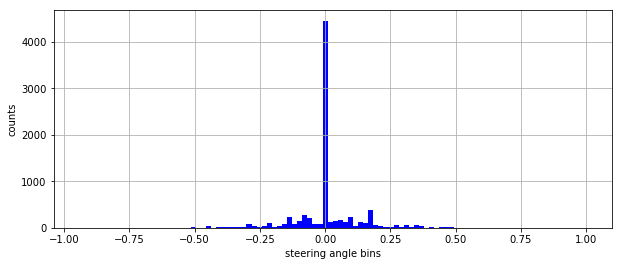

Dataset Size:  8036


In [3]:
plt.figure(figsize=(10,4))
drive_log_df.steering.hist(bins=100, color='b')
plt.xlabel('steering angle bins')
plt.ylabel('counts')
plt.show()
print("Dataset Size: ", len(drive_log_df.steering))

This data has a great pick on steering angle of 0 and it is very unbalanced. what can be done about it? we can drop 90 percent of our data that is corresponding to it.

In [4]:
zero_steering = drive_log_df[drive_log_df.steering == 0].sample(frac=0.9)
drive_log_df = drive_log_df.drop(zero_steering.index)

Cool now lets visualize it again.

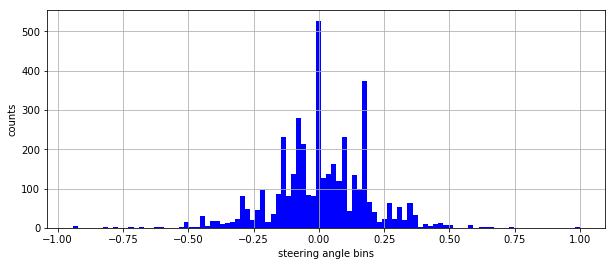

Current Dataset Size:  4111


In [5]:
plt.figure(figsize=(10,4))
drive_log_df.steering.hist(bins=100, color='b')
plt.xlabel('steering angle bins')
plt.ylabel('counts')
plt.show()
print("Current Dataset Size: ", len(drive_log_df.steering))

Much better. Two things. First we have lost a lot of data (which were not useful) also still our classes are not balanced. What can we do? Lets use data augmentation techniques to generate more data for the bins that are low in number of data points! We can flip and change the steering wheel angle.
This new driver log file is created to later support larger datasets by adding more 'meta' columns with augmentation information. You'll notice that each augmentation method adds the columns it needs to later augment the image when loaded.

In [6]:
def update_left_right_steering_correction(df):
    records = []
    for index, row in df.iterrows():
        left = row.left
        center = row.center
        right = row.right
        steering = row.steering
        
        records.append({
            'image': left,
            'steering': steering + 0.23
        })
        
        records.append({
            'image': right,
            'steering': steering - 0.23
        })
        
        records.append({
            'image': center,
            'steering': steering
        })
    
    return pd.DataFrame(data=records, columns=['image', 'steering'])

new_drive_log = update_left_right_steering_correction(drive_log_df)
new_drive_log.tail()

,image,steering
12328,IMG/right_2016_12_01_13_46_37_887.jpg,-0.23
12329,IMG/center_2016_12_01_13_46_37_887.jpg,0.00
12330,IMG/left_2016_12_01_13_46_38_395.jpg,0.23
12331,IMG/right_2016_12_01_13_46_38_395.jpg,-0.23
12332,IMG/center_2016_12_01_13_46_38_395.jpg,0.00


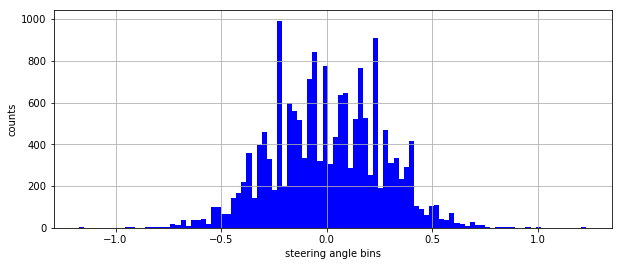

Current Dataset Size:  17092


In [7]:
def flip_images_augmentation(df):
    new_df = df[df.steering != 0].sample(frac=0.4)
    df.loc[:,'is_flipped'] = False
    new_df.loc[:,'is_flipped'] = True
    left_rows = (new_df.steering < 0)
    right_rows = (new_df.steering > 0)
    new_df.loc[left_rows,'steering'] = new_df[left_rows].steering.abs()
    new_df.loc[right_rows, 'steering'] = new_df[right_rows].steering * -1
    return pd.concat([df, new_df])

augmented = flip_images_augmentation(new_drive_log)

plt.figure(figsize=(10,4))
augmented.steering.hist(bins=100, color='b')
plt.xlabel('steering angle bins')
plt.ylabel('counts')
plt.show()
print("Current Dataset Size: ", len(augmented.steering))

Cool! Now we have more data points! boosting up to 15602 data points but still unbalanced. We have to upsample under represented example and we do this by shifting images and their corresponding angles.

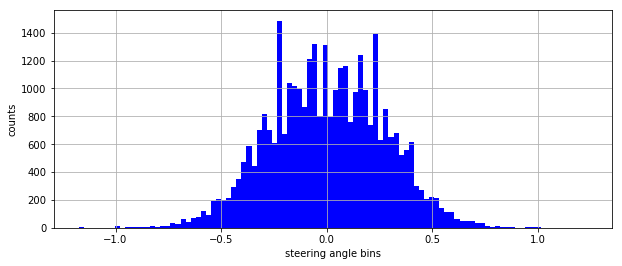

Current Dataset Size:  33748


In [8]:
def shift_img_augmentation(df):
    df.loc[:,'random_shift'] = 0
    new_df = df[df.steering != 0].copy()
    df.loc[:,'is_shift'] = False
    new_df.loc[:,'is_shift'] = True
    
    
    max_shift = 30
    max_ang = 0.17
    
    def row_shift_update(row):
        random_shift = np.random.randint(-max_shift, max_shift + 1)
        row.random_shift = random_shift
        updated_steer = row.steering + (random_shift / max_shift) * max_ang
        if abs(updated_steer) > 1:
            updated_steer = -1 if (updated_steer < 0) else 1

        row.steering = updated_steer
        return row

    new_df = new_df.apply(row_shift_update, axis=1)
    return pd.concat([df, new_df])

shifted = shift_img_augmentation(augmented)
plt.figure(figsize=(10,4))
shifted.steering.hist(bins=100, color='b')
plt.xlabel('steering angle bins')
plt.ylabel('counts')
plt.show()
print("Current Dataset Size: ", len(shifted.steering))

shifted.tail(1)
plt.show()

Even more data has been generated and the shape of the data is more like a guassian distribution and certainly more balanced but we have reated steering angles outside the bounds of [-1,1]. So lets fix that and we then we would trim the data so the end result is no bins will go past 400 examples! Cool right?

In [9]:
def process_driver_log(driver_log):
    update_log = update_left_right_steering_correction(driver_log)
    update_log = flip_images_augmentation(update_log)
    update_log = shift_img_augmentation(update_log)
    #update_log = change_brightness_augmentation(update_log)
    
    #reset index since we it's no longer good.
    update_log = update_log.reset_index(drop=True)
    
    #drop outbound steering examples to be between [-1,1] !
    outbound_steering = update_log[abs(update_log.steering) > 1]
    update_log = update_log.drop(outbound_steering.index)

    return update_log

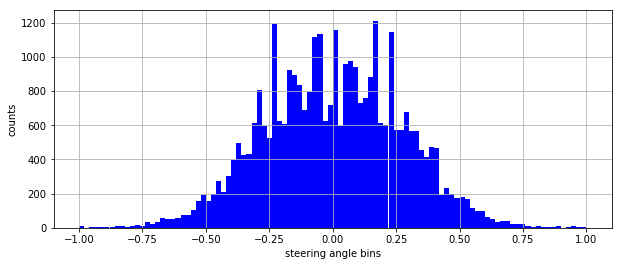

Current Dataset Size:  33738


In [10]:
processed_log = process_driver_log(drive_log_df)

plt.figure(figsize=(10,4))
processed_log.steering.hist(bins=100, color='b')
plt.xlabel('steering angle bins')
plt.ylabel('counts')
plt.show()
print("Current Dataset Size: ", len(processed_log.steering))

In [11]:
hist, counts = np.histogram(processed_log.steering, bins=100)
upper_limit = 400
over = [(i, v) for i, v in enumerate(hist) if v > upper_limit ]
over_ranges = [(counts[i],counts[i+1]) for i,_ in over]

#loop through ranges and create a mask for each bin 
masks = ["processed_log[(processed_log.steering >= {0}) & (processed_log.steering < {1})]".format(l,r) for l,r in over_ranges]

for mask in masks:
    selected = eval(mask)
    selected_length = len(selected)
    frac_to_drop = (selected_length-upper_limit)/selected_length
    samples_to_drop = selected.sample(frac=frac_to_drop)
    processed_log = processed_log.drop(samples_to_drop.index)

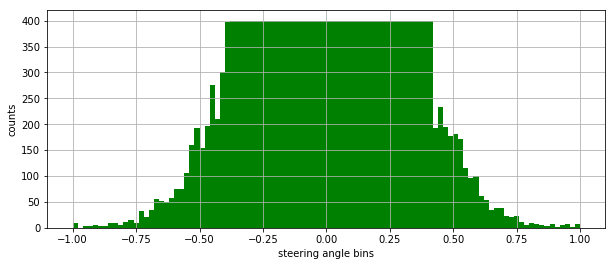

Current Dataset Size:  20362


In [12]:
plt.figure(figsize=(10,4))
processed_log.steering.hist(bins=100, color='g')
plt.xlabel('steering angle bins')
plt.ylabel('counts')
plt.show()
print("Current Dataset Size: ", len(processed_log.steering))


Now lets save our preprocessed data!

In [13]:
processed_log.to_csv('preprocessed_driver_log.csv')